For a unitary $U$ and one of its eigenvectors $|\psi\rangle$, quantum phase estimation approximates the eigenvalue $e^{-i2\pi\theta}$ by estimating the phase $\theta$ corresponding to $|\psi\rangle$.

Let's translate this to the algorithm provided by Qiskit. The phase estimation algorithm `QPE` takes following necessary the arguments:
* `operator`: This is the unitary $U$.
* `state_in`: That's eigenvector $|\psi\rangle$.
* `iqft`: Phase estimation uses an inverse quantum Fourier transform (IQFT). Since Qiskit has different implementations for this, we need to specify which IQFT we want to use.

Following your example we can set $U$ to be the Pauli $X$ operator,

$$
U = X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix},
$$

with eigenvectors 

$$
|\psi_+\rangle = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 \\ 1 \end{pmatrix}
\text{ and }
|\psi_-\rangle = \frac{1}{\sqrt{2}} \begin{pmatrix} -1 \\ 1 \end{pmatrix}.
$$

First, we'll define the operator $U = X$ in Qiskit. Note, that there are multiple ways to do this. We can either go via the matrix representation, but also via a combination of the Pauli operators. 

In [11]:
# Possibility 1: via the matrix representation
from qiskit.aqua.operators import MatrixOperator
matrix_op = MatrixOperator([[1, 0], [0, -1]])

# Possibility 2: via pauli operators
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator
pauli_op = WeightedPauliOperator.from_list([Pauli.from_label('Z')], weights=[1])  # for a simple Pauli X operator

In [17]:
qc = QuantumCircuit(1)
for pauli in pauli_op.paulis:
    print(pauli[0], pauli[1].to_matrix())

(1+0j) [[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]


Next, we'll define the eigenvector we want the eigenvalue to. Again, we can do this in multiple ways. 
If we know the statevector representation (as shown above), we can directly construct this vector using the `Custom` initial state object.

In [12]:
import numpy as np
from qiskit.aqua.components.initial_states import Custom
psi_plus_statevector = 1 / np.sqrt(2) * np.array([1, 1])
psi_plus = Custom(num_qubits=1, state_vector=psi_plus_statevector)

psi_minus_statevector = 1 / np.sqrt(2) * np.array([-1, 1])
psi_minus = Custom(num_qubits=1, state_vector=psi_minus_statevector)

Alternatively, we can also construct them from a circuit. Looking at the eigenvectors we notice that we can easily write them using single qubit gates.
For the first eigenvector:
$$
|\psi_+\rangle = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 \\ 1 \end{pmatrix} = H|0\rangle.
$$
And for the second one:
$$
|\psi_-\rangle = \frac{1}{\sqrt{2}} \begin{pmatrix} -1 \\ 1 \end{pmatrix} = Z\frac{1}{\sqrt{2}} \begin{pmatrix} 1 \\ -1 \end{pmatrix} = ZH|1\rangle = ZHX|0\rangle.
$$
Using the `QuantumCircuit` we can construct these states:

In [3]:
from qiskit import QuantumCircuit
psi_plus_circuit = QuantumCircuit(1)
psi_plus_circuit.h(0)
psi_plus = Custom(num_qubits=1, circuit=psi_plus_circuit)

psi_minus_circuit = QuantumCircuit(1)
psi_minus_circuit.x(0)
psi_minus_circuit.h(0)
psi_minus_circuit.z(0)
psi_minus = Custom(num_qubits=1, circuit=psi_plus_circuit)

Now, obviously, if we precisely know the eigenvectors finding the eigenvalues is not the most interesting task. But even if we didn't know the eigenvectors we could still apply phase estimation. In this case, the algorithm returns either an eigenvalue of $|\psi_+\rangle$ or of $|\psi_-\rangle$. The probability of getting either one is determined by the overlap of the state $|\psi\rangle$ we feed into phase estimation with $|\psi_+\rangle$ or $|\psi_-\rangle$.

The final step is to choose an IQFT. Qiskit provides the `Standard` and `Approximate` IQFT. As the names already state `Standard` is the usual IQFT, whereas `Approximate` is an approximate implementation using less gates.

Note, that these classes expect the number of qubits as argument. This determines on how many qubits the IQFT acts on. In phase estimation this is the number of times we apply controlled powers of $U$, or the number $n$ in the image of [Wikipedia](https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm#/media/File:PhaseCircuit-crop.svg) you linked.

In [4]:
from qiskit.aqua.components.iqfts import Standard, Approximate
n = 2  # let's set the number of qubits to 4, we'll specify that in QPE later on
iqft = Standard(n)

Let's put all the pieces together!

In [13]:
from qiskit.aqua.algorithms import QPE
qpe = QPE(operator=matrix_op, state_in=psi_plus, iqft=iqft, num_ancillae=n)  # remember to specify n!

To run the algorithm, we need a simulator. To get the exact, theoretical result we can use the `statevector_simulator`. To simulate the behaviour of a quantum computer and actual measurements, use the `qasm_simulator`. 

In [14]:
from qiskit import BasicAer  # Aer for better performance, requires Qiskit Aer to be installed
backend = BasicAer.get_backend('statevector_simulator')

result = qpe.run(backend)
print(result)

{'_basis': [(Pauli(z=[True], x=[False]), [0]), (Pauli(z=[False], x=[False]), [1])], '_z2_symmetries': None, '_name': '', '_paulis_table': {'Z': 0, 'I': 1}, '_paulis': [[(0.5+0j), Pauli(z=[True], x=[False])], [(0.5+0j), Pauli(z=[False], x=[False])]], '_atol': 1e-12}
{'translation': 1.0, 'stretch': 0.5, 'top_measurement_label': '00', 'top_measurement_decimal': 0.0, 'eigvals': [-1.0], 'energy': -1.0}


In [7]:
# qpe = QPE(operator=matrix_op, state_in=Custom(1, state_vector=np.array([0, 1])), iqft=iqft, num_ancillae=n)  # remember to specify n!
# result = qpe.run(backend)
#print(result)

In [8]:
circuit = QuantumCircuit(1)
#circuit.x(0)
qpe = QPE(operator=pauli_op, state_in=Custom(1, circuit=circuit), iqft=iqft, num_ancillae=n)  # remember to specify n!
result = qpe.run(backend)
print(result)

{'_basis': [(Pauli(z=[True], x=[False]), [0]), (Pauli(z=[False], x=[False]), [1])], '_z2_symmetries': None, '_name': '', '_paulis_table': {'Z': 0, 'I': 1}, '_paulis': [[(0.5+0j), Pauli(z=[True], x=[False])], [(0.5+0j), Pauli(z=[False], x=[False])]], '_atol': 1e-12}
{'00': 1024}
{'translation': 1.0, 'stretch': 0.5, 'top_measurement_label': '00', 'top_measurement_decimal': 0.0, 'eigvals': [-1.0], 'energy': -1.0}


{'_basis': [(Pauli(z=[True], x=[False]), [0]), (Pauli(z=[False], x=[False]), [1])], '_z2_symmetries': None, '_name': '', '_paulis_table': {'Z': 0, 'I': 1}, '_paulis': [[(0.5+0j), Pauli(z=[True], x=[False])], [(0.5+0j), Pauli(z=[False], x=[False])]], '_atol': 1e-12}


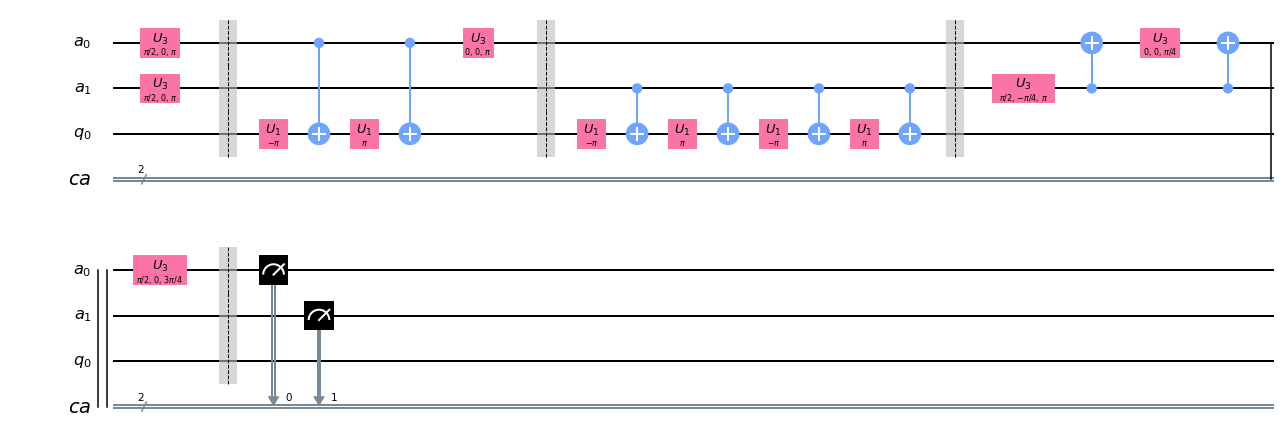

In [9]:
from qiskit import transpile
transpile(qpe.construct_circuit(), optimization_level=3).decompose().draw(output='mpl')

In [10]:
qc = QuantumCircuit(2)
qc.cz(0, 1)
qc.decompose().draw()

In [26]:
from qiskit import execute, Aer
np.set_printoptions(precision=2)
qc = QuantumCircuit(2)
#qc.u1(-np.pi, 1)
qc.cz(0, 1)
#qc.u1(np.pi, 1)
#qc.cx(0,1)
# qc.u3(0, 0, np.pi, 0)
result = execute(qc, Aer.get_backend('unitary_simulator'), shots=1).result()
print(result.get_unitary().real)
print(result.get_unitary().imag)

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [4]:
import numpy as np

from qiskit import BasicAer  
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom
from qiskit.aqua.components.iqfts import Standard, Approximate
from qiskit.aqua.algorithms import QPE

backend = BasicAer.get_backend('statevector_simulator')

# the operator U: set to be a Pauli Z operator
pauli_op = WeightedPauliOperator.from_list([Pauli.from_label('Z')], weights=[1])  # for a simple Pauli X operator

# its eigenvectors, the |0> and |1> state
psi_plus_statevector = np.array([1, 0])
psi_plus = Custom(num_qubits=1, state_vector=psi_plus_statevector)

psi_minus_statevector = np.array([0, 1])
psi_minus = Custom(num_qubits=1, state_vector=psi_minus_statevector)

# and the IQFT
n = 1  # num_ancillae in QPE
iqft = Standard(n)

for name, state in zip(['|0>', '|1>'], [psi_plus, psi_minus]):
    qpe = QPE(operator=pauli_op, state_in=state, iqft=iqft, num_ancillae=n) 
    result = qpe.run(backend)
    print(f'using {name} as start state:\n', result)

using |0> as start state:
 {'translation': 1.0, 'stretch': 0.5, 'top_measurement_label': '0', 'top_measurement_decimal': 0.0, 'eigvals': [-1.0], 'energy': -1.0}
using |1> as start state:
 {'translation': 1.0, 'stretch': 0.5, 'top_measurement_label': '0', 'top_measurement_decimal': 0.0, 'eigvals': [-1.0], 'energy': -1.0}
